In [32]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df=pd.read_csv('../data/bikedata.csv')
df.head()

,name,latitude,longitude,free_bikes,empty_slots,total_bike_cap,uid,renting,returning,last_updated,has_ebikes,ebikes,payment,payment-terminal,slots,rental_uris.android,rental_uris.ios
0,Fairfax Dr & Wilson Blvd,38.885801,-77.097745,5,6,11,08251ded-1f3f-11e7-bf6b-3863bb334450,1,1,1729395530,True,3,"['key', 'creditcard']",True,12,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan
1,South St & University Dr,38.844249,-77.305336,11,1,12,1877158937567185816,1,1,1729395487,True,0,"['key', 'creditcard']",True,12,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan
2,White Oak Rec Center,39.046143,-76.975723,6,9,15,2213781a-5c69-43eb-9b33-346d61e7e1ba,1,1,1729395477,True,0,"['key', 'creditcard']",True,15,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan
3,Fessenden St & Wisconsin Ave NW,38.954812,-77.082426,1,14,15,08254529-1f3f-11e7-bf6b-3863bb334450,1,1,1729395578,True,0,"['key', 'creditcard']",True,15,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan
4,Fenton St & Gist Ave,38.989724,-77.023854,6,5,11,0825ac97-1f3f-11e7-bf6b-3863bb334450,1,1,1729395538,True,5,"['key', 'creditcard']",True,11,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan


# Foursquare

Send a request to Foursquare with a small radius (1000m) for all the bike stations in your city of choice. 

In [19]:
api_key = os.environ['foursquareapi']
latitude = ""
longitude = ''
radius = str(500)
categories = '13003,12057,12061'
headers = {"Accept": "application/json"}
headers['Authorization'] = api_key
foursquaredata = pd.DataFrame()

for index, row in df.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    url = f"https://api.foursquare.com/v3/places/search?ll={latitude},{longitude}&radius={radius}&categories={categories}&fields=name,rating,location,popularity,distance,categories"
    result = requests.get(url, headers=headers)
    data = result.json()
    result_df = pd.json_normalize(data.get('results', []))
    if not result_df.empty:
        result_df['station'] = row['name']
        foursquaredata = pd.concat([foursquaredata, result_df], ignore_index=True)



Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc). 

In [114]:
foursquaredata.head()

,categories,distance,name,popularity,rating,location.address,location.census_block,location.country,location.cross_street,location.dma,location.formatted_address,location.locality,location.postcode,location.region,location.address_extended,station
0,"[{'id': 13003, 'name': 'Bar', 'short_name': 'B...",97,The Liberty Tavern,0.982389,8.5,3195 Wilson Blvd,510131015022016,US,Washington Blvd,"Washington, Dc-Hagrstwn","3195 Wilson Blvd (Washington Blvd), Arlington,...",Arlington,22201,VA,NaN,Fairfax Dr & Wilson Blvd
1,"[{'id': 13003, 'name': 'Bar', 'short_name': 'B...",240,Lyon Hall,0.982187,8.5,3100 Washington Blvd,510131019001002,US,at N Highland St.,"Washington, Dc-Hagrstwn","3100 Washington Blvd (at N Highland St.), Arli...",Arlington,22201,VA,NaN,Fairfax Dr & Wilson Blvd
2,"[{'id': 13007, 'name': 'Beer Garden', 'short_n...",131,The Lot,0.972111,8.0,3217 10th St N,510131019001004,US,,"Washington, Dc-Hagrstwn","3217 10th St N, Arlington, VA 22201",Arlington,22201,VA,NaN,Fairfax Dr & Wilson Blvd
3,"[{'id': 13015, 'name': 'Karaoke Bar', 'short_n...",62,O'Sullivan's Irish Pub,0.980685,7.5,3207 Washington Blvd,510131015022017,US,at Wilson Blvd.,"Washington, Dc-Hagrstwn","3207 Washington Blvd (at Wilson Blvd.), Arling...",Arlington,22201,VA,NaN,Fairfax Dr & Wilson Blvd
4,"[{'id': 13025, 'name': 'Wine Bar', 'short_name...",442,Screwtop Wine Bar,0.965211,8.5,1025 N Fillmore St,510131018011002,US,NaN,"Washington, Dc-Hagrstwn","1025 N Fillmore St, Arlington, VA 22201",Arlington,22201,VA,Ste C,Fairfax Dr & Wilson Blvd


There are 56 null values in foursquare ratings but I am keeping them in for now because I want to see them with the yelp data in the next stage. The data may be offices and that makes sense that no one has rated them yet.

In [115]:
foursquareparsed = foursquaredata[['station','distance','name','location.address','rating','popularity','categories']]
foursquareparsed.loc[:, 'categories']= foursquareparsed['categories'].apply(lambda x: [cat['name'] for cat in x])

In [116]:
foursquareparsed.loc[:, 'categories'] = foursquareparsed['categories'].apply(lambda x: 'bar' if any('bar' in category.lower() for category in x) or any('pub' in category.lower() for category in x) or any('restaurant' in category.lower() for category in x) else 'school')

In [117]:
foursquareparsed.head()

,station,distance,name,location.address,rating,popularity,categories
0,Fairfax Dr & Wilson Blvd,97,The Liberty Tavern,3195 Wilson Blvd,8.5,0.982389,bar
1,Fairfax Dr & Wilson Blvd,240,Lyon Hall,3100 Washington Blvd,8.5,0.982187,bar
2,Fairfax Dr & Wilson Blvd,131,The Lot,3217 10th St N,8.0,0.972111,bar
3,Fairfax Dr & Wilson Blvd,62,O'Sullivan's Irish Pub,3207 Washington Blvd,7.5,0.980685,bar
4,Fairfax Dr & Wilson Blvd,442,Screwtop Wine Bar,1025 N Fillmore St,8.5,0.965211,bar


# Foursquare EDA

In [41]:
print(f"Shape of the dataset: {foursquareparsed.shape}")

print(foursquareparsed.head())

print(foursquareparsed.info())

print(foursquareparsed.isnull().sum())

print(foursquareparsed.describe())

Shape of the dataset: (389, 7)
                    station  distance                    name  \
0  Fairfax Dr & Wilson Blvd        97      The Liberty Tavern   
1  Fairfax Dr & Wilson Blvd       240               Lyon Hall   
2  Fairfax Dr & Wilson Blvd       131                 The Lot   
3  Fairfax Dr & Wilson Blvd        62  O'Sullivan's Irish Pub   
4  Fairfax Dr & Wilson Blvd       442       Screwtop Wine Bar   

       location.address  rating  popularity categories  
0      3195 Wilson Blvd     8.5    0.982389        bar  
1  3100 Washington Blvd     8.5    0.982187        bar  
2        3217 10th St N     8.0    0.972111        bar  
3  3207 Washington Blvd     7.5    0.980685        bar  
4    1025 N Fillmore St     8.5    0.965211        bar  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           389 non-null   

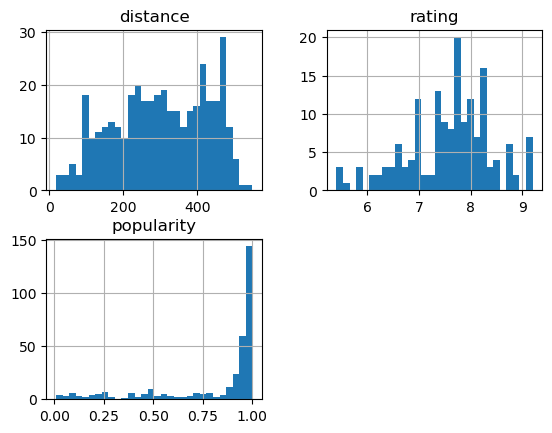

In [42]:
foursquareparsed.hist(bins=30)
plt.show()

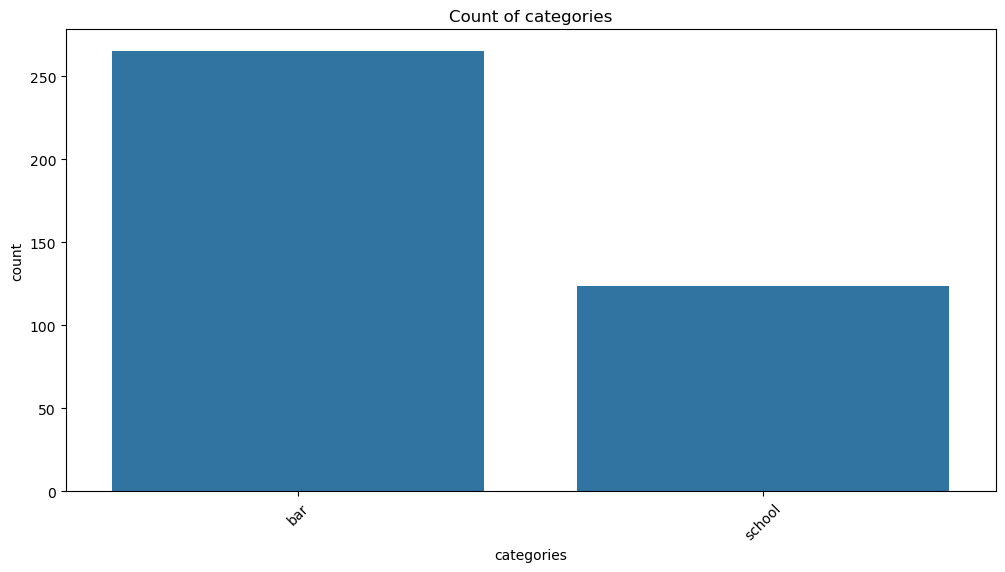

In [43]:
plt.figure(figsize=(12, 6))
sns.countplot(data=foursquareparsed, x='categories')
plt.xticks(rotation=45)
plt.title('Count of categories')
plt.show()

Results into CSV for next steps

In [51]:
foursquareparsed.to_csv('../data/foursqdata.csv', index=False)

# Yelp

Send a request to Yelp with a small radius (1000m) for all the bike stations in your city of choice. 

In [ ]:
yelp_api_key = os.environ['yelpapi']
latitude = ""
longitude = ''
radius = str(500)
categories = 'bars,elementaryschools,highschools,privateschools'
headers = {"Accept": "application/json"}
headers['Authorization'] = f"Bearer {yelp_api_key}"
yelpdataframes = []
for index, row in df.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    url = f"https://api.yelp.com/v3/businesses/search?latitude={latitude}&longitude={longitude}&radius={radius}&categories={categories}"
    result = requests.get(url, headers=headers)
    print(f"Status: {result.status_code}")
    data = result.json()
    result_df = pd.json_normalize(data.get('businesses', []))
    if not result_df.empty:
        result_df['station'] = row['name']
        yelpdataframes.append(result_df)
yelpdata = pd.concat(yelpdataframes, ignore_index=True) if yelpdataframes else pd.DataFrame()


In [89]:
yelpdata.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,location.city,location.zip_code,location.country,location.state,location.display_address,attributes.business_temp_closed,attributes.menu_url,attributes.open24_hours,attributes.waitlist_reservation,station
0,wwaLUZAeeDrYgjenSEXdKQ,the-liberty-tavern-arlington,The Liberty Tavern,https://s3-media1.fl.yelpcdn.com/bphoto/iiaVXg...,False,https://www.yelp.com/biz/the-liberty-tavern-ar...,1504,"[{'alias': 'bars', 'title': 'Bars'}, {'alias':...",3.8,"[delivery, pickup]",...,Arlington,22201,US,VA,"[3195 Wilson Blvd, Arlington, VA 22201]",None,https://www.thelibertytavern.com/menus/#dinner/,None,None,Fairfax Dr & Wilson Blvd
1,iYvyq7mC54tl-90XRC9jHg,smokecraft-modern-barbecue-arlington,Smokecraft Modern Barbecue,https://s3-media1.fl.yelpcdn.com/bphoto/W_g9HO...,False,https://www.yelp.com/biz/smokecraft-modern-bar...,476,"[{'alias': 'bbq', 'title': 'Barbeque'}, {'alia...",4.3,"[delivery, pickup]",...,Arlington,22201,US,VA,"[1051 N Highland St, Arlington, VA 22201]",None,http://www.smokecraftbbq.com/menu,None,False,Fairfax Dr & Wilson Blvd
2,MXlddvoKWBEtNWBAxeY_YA,don-tito-arlington,Don Tito,https://s3-media4.fl.yelpcdn.com/bphoto/Yn3ERe...,False,https://www.yelp.com/biz/don-tito-arlington?ad...,928,"[{'alias': 'mexican', 'title': 'Mexican'}, {'a...",3.6,"[delivery, pickup]",...,Arlington,22201,US,VA,"[3165 Wilson Blvd, Arlington, VA 22201]",None,None,None,True,Fairfax Dr & Wilson Blvd
3,-dRL6yDxKwoth6KlloMrLg,northside-social-coffee-and-wine-arlington,Northside Social Coffee & Wine,https://s3-media3.fl.yelpcdn.com/bphoto/nlDRQv...,False,https://www.yelp.com/biz/northside-social-coff...,1396,"[{'alias': 'tradamerican', 'title': 'American'...",4.0,[delivery],...,Arlington,22201,US,VA,"[3211 Wilson Blvd, Arlington, VA 22201]",None,,None,None,Fairfax Dr & Wilson Blvd
4,rQKablrIou5oMVT-eegH8g,circa-at-clarendon-arlington,CIRCA at Clarendon,https://s3-media4.fl.yelpcdn.com/bphoto/xgxD0k...,False,https://www.yelp.com/biz/circa-at-clarendon-ar...,684,"[{'alias': 'newamerican', 'title': 'New Americ...",3.9,"[delivery, pickup]",...,Arlington,22201,US,VA,"[3010 Clarendon Blvd, Arlington, VA 22201]",None,https://www.circabistros.com/location/clarendo...,None,None,Fairfax Dr & Wilson Blvd


In [105]:
yelpparsed = yelpdata[['station','distance','name','location.address1','rating','categories']]
yelpparsed=yelpparsed.rename(columns={'location.address1': 'location.address'})
yelpparsed.loc[:, 'categories']= yelpparsed['categories'].apply(lambda x: [cat['title'] for cat in x])



In [106]:
yelpparsed.head()

,station,distance,name,location.address,rating,categories
0,Fairfax Dr & Wilson Blvd,99.811027,The Liberty Tavern,3195 Wilson Blvd,3.8,"[Bars, New American, Breakfast & Brunch]"
1,Fairfax Dr & Wilson Blvd,274.193799,Smokecraft Modern Barbecue,1051 N Highland St,4.3,"[Barbeque, American, Whiskey Bars]"
2,Fairfax Dr & Wilson Blvd,154.341780,Don Tito,3165 Wilson Blvd,3.6,"[Mexican, Bars]"
3,Fairfax Dr & Wilson Blvd,42.681591,Northside Social Coffee & Wine,3211 Wilson Blvd,4.0,"[American, Coffee & Tea, Wine Bars]"
4,Fairfax Dr & Wilson Blvd,361.315313,CIRCA at Clarendon,3010 Clarendon Blvd,3.9,"[New American, Wine Bars, Breakfast & Brunch]"


In [107]:
# Function to check for 'bar' and replace the list with 'bar' if found
def check_bar(categories):
    # Convert to lower case and check if 'bar' is in the list
    if any('Bars' in category for category in categories):
        return 'bar'
    else:
        return 'school'

# Apply the function to the 'categories' column
yelpparsed.loc[:,'categories'] = yelpparsed['categories'].apply(check_bar)

# Output the modified DataFrame
yelpparsed.head()


,station,distance,name,location.address,rating,categories
0,Fairfax Dr & Wilson Blvd,99.811027,The Liberty Tavern,3195 Wilson Blvd,3.8,bar
1,Fairfax Dr & Wilson Blvd,274.193799,Smokecraft Modern Barbecue,1051 N Highland St,4.3,bar
2,Fairfax Dr & Wilson Blvd,154.341780,Don Tito,3165 Wilson Blvd,3.6,bar
3,Fairfax Dr & Wilson Blvd,42.681591,Northside Social Coffee & Wine,3211 Wilson Blvd,4.0,bar
4,Fairfax Dr & Wilson Blvd,361.315313,CIRCA at Clarendon,3010 Clarendon Blvd,3.9,bar


# Yelp EDA

In [108]:
print(f"Shape of the dataset: {yelpparsed.shape}")

print(yelpparsed.head())

print(yelpparsed.isnull().sum())

print(yelpparsed.describe())

print(yelpparsed.info())


Shape of the dataset: (534, 6)
                    station    distance                            name  \
0  Fairfax Dr & Wilson Blvd   99.811027              The Liberty Tavern   
1  Fairfax Dr & Wilson Blvd  274.193799      Smokecraft Modern Barbecue   
2  Fairfax Dr & Wilson Blvd  154.341780                        Don Tito   
3  Fairfax Dr & Wilson Blvd   42.681591  Northside Social Coffee & Wine   
4  Fairfax Dr & Wilson Blvd  361.315313              CIRCA at Clarendon   

      location.address  rating categories  
0     3195 Wilson Blvd     3.8        bar  
1   1051 N Highland St     4.3        bar  
2     3165 Wilson Blvd     3.6        bar  
3     3211 Wilson Blvd     4.0        bar  
4  3010 Clarendon Blvd     3.9        bar  
station             0
distance            0
name                0
location.address    1
rating              0
categories          0
dtype: int64
           distance      rating
count    534.000000  534.000000
mean     668.375374    3.235955
std     3117.

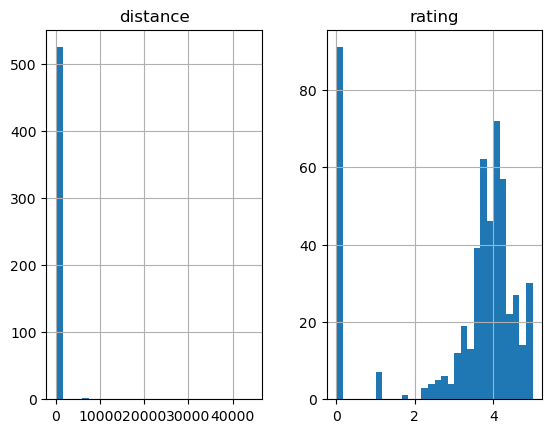

In [109]:
yelpparsed.hist(bins=30)
plt.show()

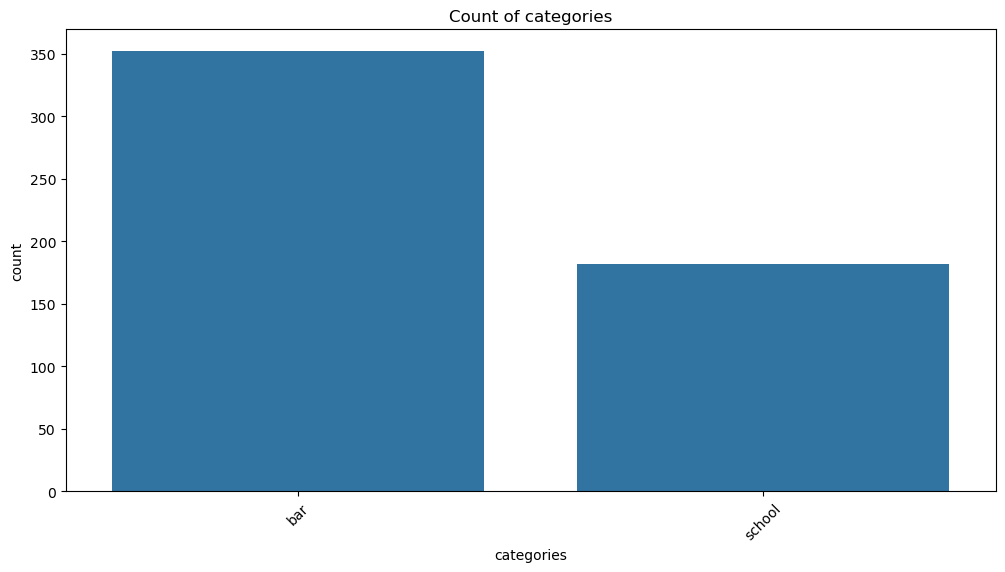

In [110]:
plt.figure(figsize=(12, 6))
sns.countplot(data=yelpparsed, x='categories')
plt.xticks(rotation=45)
plt.title('Count of categories')
plt.show()

Results into a CSV for next steps

In [111]:
yelpparsed.to_csv('../data/yelpdata.csv', index=False)

# Comparing Results

Which API provided you with more complete data? Provide an explanation. 

Yelp provided the more complete data. Foursquare had a significant amount of null values in their ratings column. They also had a significant amount of nulls in their popularity column so substituting one for the other is not possible.

Get the top 10 restaurants according to their rating

Yelp top 10

In [112]:
yelptop10 = yelpparsed.sort_values(by='rating', ascending=False).reset_index(drop=True).head(10)
yelptop10

,station,distance,name,location.address,rating,categories
0,University Dr & Democracy Ln,420.332019,Roman's Robots,,5.0,school
1,Gatehouse Rd & Telestar Ct,107.758301,FCPS Grab and Go Meals,8115 Gatehouse Rd,5.0,school
2,South St & University Dr,225.095598,Roman's Robots,,5.0,school
3,Fessenden St & Wisconsin Ave NW,364.137521,Georgetown Day School Lower Middle School,4530 MacArthur Blvd NW,5.0,school
4,George Mason Dr & Wilson Blvd,137.650295,Arlington Traditional School,855 N Edison St,5.0,school
5,Fessenden St & Wisconsin Ave NW,300.864023,Georgetown Day School High School,4200 Davenport St NW,5.0,school
6,Connecticut Ave & Chevy Chase Lake Dr,239.383089,Uncorked Chevy Chase,8525 Chevy Chase Lake Ter,5.0,bar
7,Arlington Blvd & S George Mason Dr,352.029506,Tobacco & Vape King,55 N Glebe Rd Arlington,5.0,bar
8,Fairfax Dr & N Taylor St,155.906878,Kinhaven School,4201 Fairfax Dr,5.0,school
9,Rockville Metro West,472.541453,St. Mary's Preschool,600 Viers Mill Rd,5.0,school


Foursquare top 10

In [118]:
foursqtop10 = foursquareparsed.sort_values(by='rating', ascending=False).reset_index(drop=True).head(10)
foursqtop10

,station,distance,name,location.address,rating,popularity,categories
0,Adams Mill & Columbia Rd NW,378,The Green Zone,2226 18th St NW,9.2,0.982717,bar
1,Veterans Pl & Pershing Dr,475,Quarry House Tavern,8401 Georgia Ave,9.1,0.998341,bar
2,Adams Mill & Columbia Rd NW,208,Lapis,1847 Columbia Rd NW,9.1,0.978430,bar
3,W Columbia St & N Washington St,441,South Block Co,2121 N Westmoreland St,9.1,0.969570,bar
4,Fenton St & Gist Ave,482,Quarry House Tavern,8401 Georgia Ave,9.1,0.998341,bar
5,Founders Row/W Broad St & West St,28,Dominion Wine and Beer,107 Rowell Ct,9.1,0.982537,bar
6,Fenton St & Gist Ave,268,Kaldi's Social House,918 Silver Spring Ave,9.1,0.998530,bar
7,Columbia Rd & Georgia Ave NW,161,Doubles,3118 Georgia Ave NW,8.9,0.973061,bar
8,New Hampshire Ave & Ward Pl NW,83,Mercy Me DC Restaurant,1143 New Hampshire Ave NW,8.9,0.984984,bar
9,Columbia Rd & Georgia Ave NW,485,El Chucho Cocina Superior,3313 11th St NW,8.8,0.971779,bar
